# MGTA415 Group Project
## Reviews Analysis And Recommendation System For E-commerce Retails

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import time

from unidecode import unidecode
import contractions
import itertools
from collections import Counter

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
from gensim.models import word2vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfTransformer,
    TfidfVectorizer,
)
from sklearn import metrics
from sklearn.metrics import f1_score
import xgboost
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from math import sqrt
import warnings
from wordcloud import WordCloud
warnings.filterwarnings("ignore")

## Load data

In [2]:
reviews=pd.read_csv("data/Womens Clothing E-Commerce Reviews.csv")
reviews["Rating"]=reviews["Rating"].astype("category")
reviews=reviews[reviews['Review Text'].notnull()]
reviews.head(2)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses


In [3]:
reviews.Rating.value_counts()

5    12540
4     4908
3     2823
2     1549
1      821
Name: Rating, dtype: int64

## Data preprocessing

### 2.1 inital method

In [4]:
def text_clean(df,colname):

    nltk.download('stopwords')
    stop_words = stopwords.words('english')
#     stop_words.extend(add_stop_words)
    stop_words = set(stop_words)
    ps = PorterStemmer()
    
    preprocessed_t_sentences = []
        
    for i, row in df.iterrows():
        # Expand contractions
        sent= contractions.fix(str(row[colname]))
        # Remove HTML tags
        sent=re.sub("(<.*?>)","",sent)
        # Remove numbers and puncs
        sent=re.sub("(\r\n)"," ",sent)
        sent=re.sub("[^a-zA-Z\s]"," ",sent.lower())
        sent=re.sub("\s+"," ",sent)
        sent=re.sub(r'([\w])\1\1+', r'\1', sent)
#         sent_t=re.sub("(\\W|\\d)"," ",sent_t)
        words_list = sent.strip().split()
        #lowercasing, standardized english, remove stop words
        filtered_words = [ps.stem(unidecode(word)) for word in words_list if word not in stop_words and len(word) != 1 and ps.stem(word) not in stop_words]
#         preprocessed_t_sentences.append(" ".join(filtered_t_words))
#         preprocessed_t_sentences.append(filtered_t_words)
        preprocessed_t_sentences.append(" ".join(filtered_words))
    df[colname+"_processed"]=preprocessed_t_sentences
    return df

In [5]:
df=text_clean(reviews,"Review Text")
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     D:\WispZ\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Review Text_processed
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,absolut wonder silki sexi comfort
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,love dress pretti happen find store glad bc ne...
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,high hope dress realli want work initi order p...
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,love love love jumpsuit fun flirti fabul everi...
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,shirt flatter due adjust front tie perfect len...


### 2.2 filter low frequency words

In [6]:
tagged_data=[d for d in df["Review Text_processed"].apply(lambda x:x.split(" "))]
word_counts=Counter(itertools.chain(*tagged_data))
freq_dict={pair[0]:pair[1] for pair in word_counts.most_common()}
df_freq=pd.DataFrame(freq_dict.items()).rename(columns={0:"word",1:"freq"})
low_frequent_words=df_freq[df_freq.freq<5].word.tolist()
len(low_frequent_words)

5768

In [7]:
def text_clean_freq(df,colname,low_freq_list):

    nltk.download('stopwords')
    stop_words = stopwords.words('english')
    stop_words.extend(low_freq_list)
    stop_words = set(stop_words)
    ps = PorterStemmer()
    
    preprocessed_t_sentences = []
        
    for i, row in df.iterrows():
        # Expand contractions
        sent= contractions.fix(str(row[colname]))
        # Remove HTML tags
        sent=re.sub("(<.*?>)","",sent)
        # Remove numbers and puncs
        sent=re.sub("(\r\n)"," ",sent)
        sent=re.sub("[^a-zA-Z\s]"," ",sent.lower())
        sent=re.sub("\s+"," ",sent)
        sent=re.sub(r'([\w])\1\1+', r'\1', sent)
#         sent_t=re.sub("(\\W|\\d)"," ",sent_t)
        words_list = sent.strip().split()
        #lowercasing, standardized english, remove stop words
        filtered_words = [ps.stem(unidecode(word)) for word in words_list if word not in stop_words and len(word) != 1 and ps.stem(word) not in stop_words]
#         preprocessed_t_sentences.append(" ".join(filtered_t_words))
#         preprocessed_t_sentences.append(filtered_t_words)
        preprocessed_t_sentences.append(" ".join(filtered_words))
    df[colname+"_processed"]=preprocessed_t_sentences
    return df

In [8]:
df_lf=text_clean_freq(reviews,"Review Text",low_frequent_words)
df_lf.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     D:\WispZ\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Review Text_processed
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,absolut wonder silki comfort
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,love dress pretti happen find store glad bc ne...
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,high hope dress realli want work initi order p...
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,love love love jumpsuit fun flirti fabul everi...
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,shirt flatter due adjust front tie perfect len...


## Exploratory Data Analysis

In [9]:
sns.set_style("whitegrid")
test = df_lf
test = test[~test['Review Text'].isnull()]

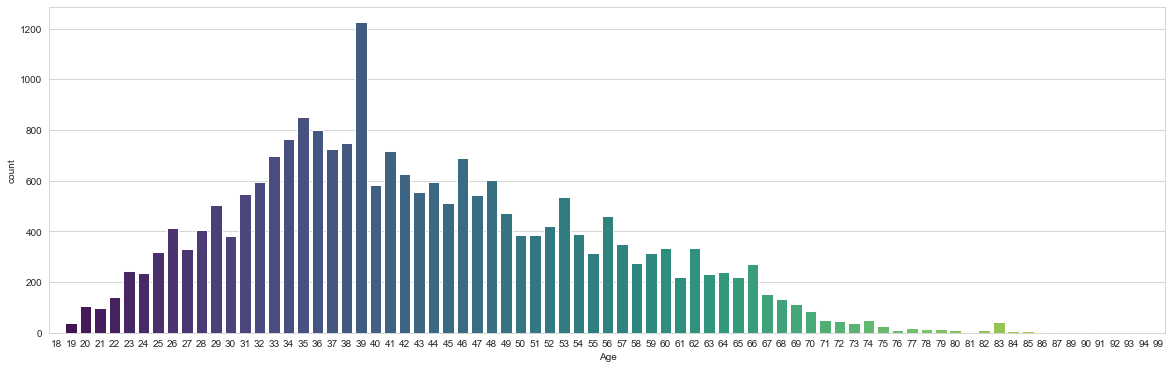

In [10]:
plt.figure(figsize = (20,6))
ax = sns.countplot(x = 'Age', data = reviews,palette = 'viridis')

plt.show()
figure = ax.get_figure() 
figure.savefig('age.png', dpi=500)

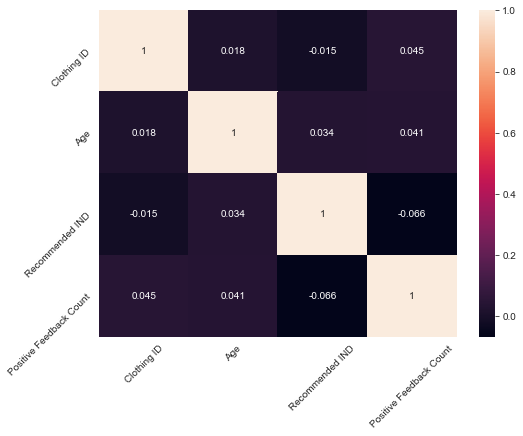

In [11]:
plt.figure(figsize = (8,6))
y = test['Review Text_processed']
X = test.drop(columns = 'Review Text_processed')
X = X.drop(columns ='Unnamed: 0')
sns.heatmap(X.corr(), annot = True )
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.savefig('heatmap.png', dpi=500)

### WordCloud

In [13]:
nltk.download('brown')

[nltk_data] Downloading package brown to /home/jovyan/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


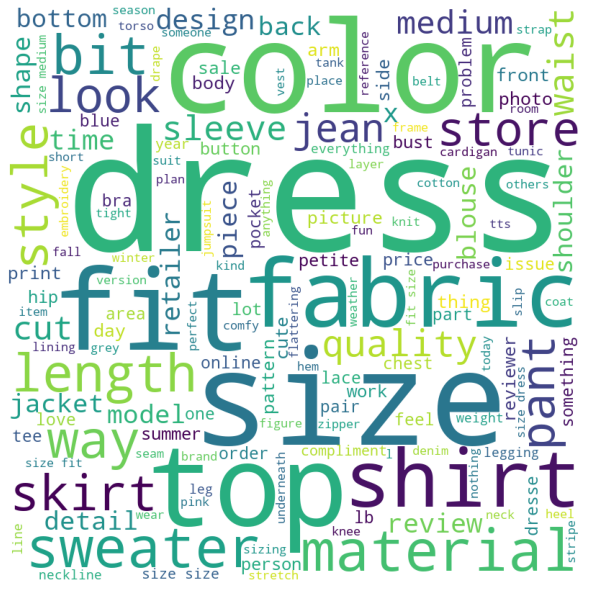

In [22]:
from textblob import *
nltk.download('averaged_perceptron_tagger')
comment_words = '' 
stop_words = set(stopwords.words("english"))
for val in reviews['Review Text']: 
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
  
    comment_words += " ".join(tokens)+" "


def extract_NN(sent):
    grammar = r"""
    NBAR:
        # Nouns and Adjectives, terminated with Nouns
        {<NN.*>*<NN.*>}

    NP:
        {<NBAR>}
        # Above, connected with in/of/etc...
        {<NBAR><IN><NBAR>}
    """
    chunker = nltk.RegexpParser(grammar)
    ne = ''
    chunk = chunker.parse(nltk.pos_tag(nltk.word_tokenize(sent)))
    for tree in chunk.subtrees(filter=lambda t: t.label() == 'NP'):
        ne += ' '.join([child[0] for child in tree.leaves()]) + " "
    return ne

words = extract_NN(comment_words)
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stop_words,
                min_font_size = 16).generate(words) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
ax = plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 
figure = ax.get_figure() 
figure.savefig('wordcloud.png', dpi=500)

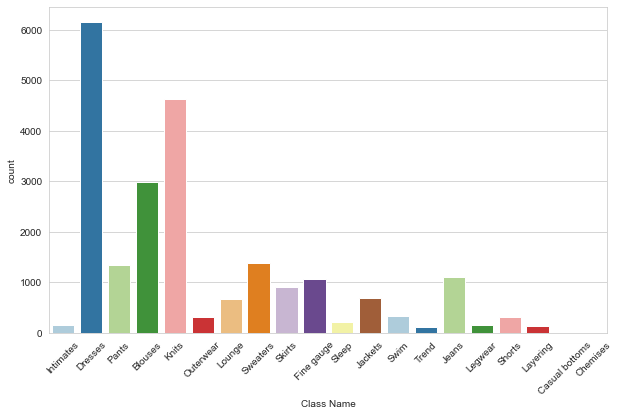

In [12]:
plt.figure(figsize = (10,6))
ax = sns.countplot(x = 'Class Name', data = test,palette = 'Paired')
plt.xticks(rotation = 45)
plt.show()
figure = ax.get_figure() 
figure.savefig('category.png', dpi=500)

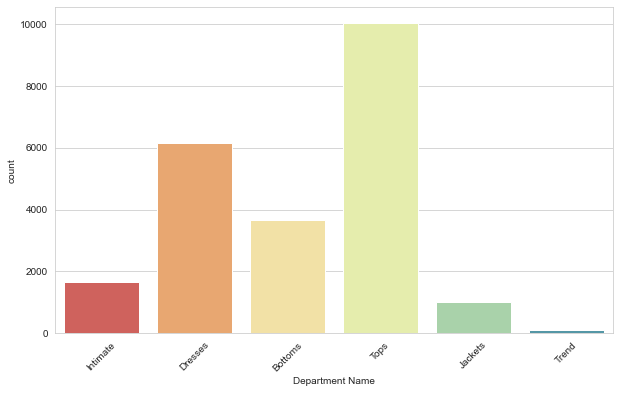

In [13]:
plt.figure(figsize = (10,6))
ax = sns.countplot(x = 'Department Name', data = test,palette = 'Spectral')
plt.xticks(rotation = 45)
plt.show()
figure = ax.get_figure() 
figure.savefig('Department.png', dpi=500)

### Unigram and Bigram

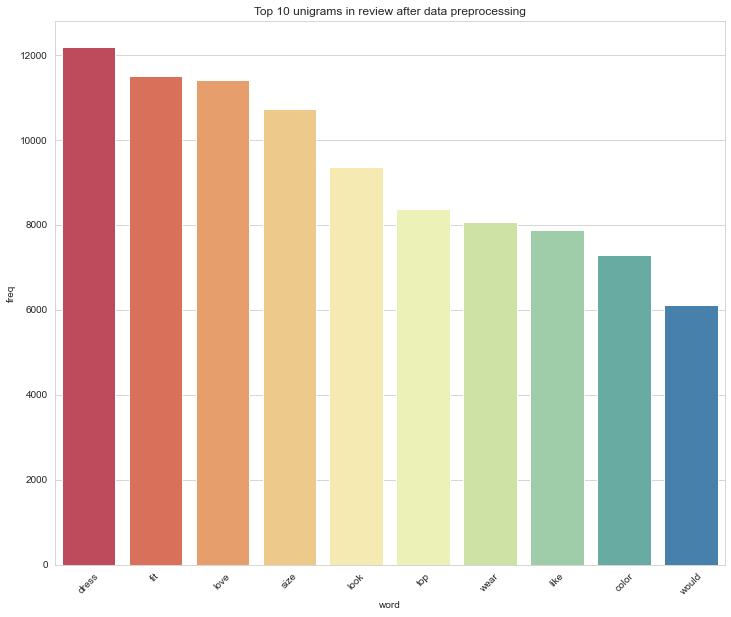

In [14]:
plt.figure(figsize = (12,10))
sns.barplot(data = df_freq[:10],y = 'freq',x = 'word',palette = 'Spectral').set_title('Top 10 unigrams in review after data preprocessing') 
plt.xticks(rotation = 45)
plt.savefig('Frequent Words.png', dpi=400)

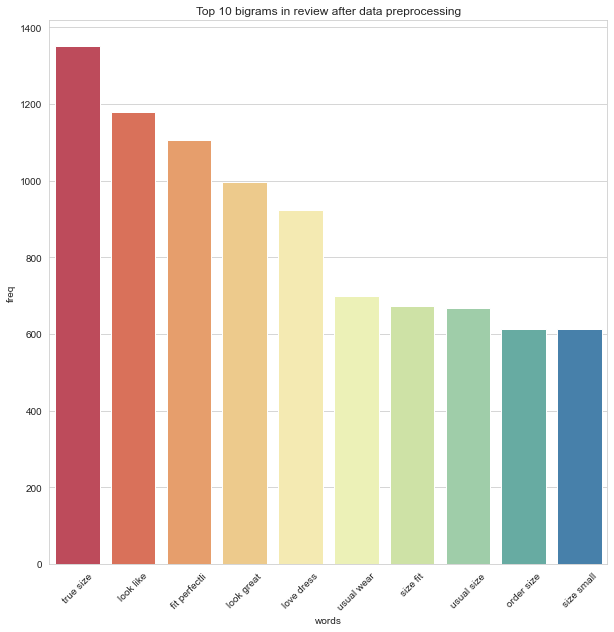

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
def top_n_ngram(corpus,n = None,ngram = 1):
    vec = CountVectorizer(stop_words = 'english',ngram_range=(ngram,ngram)).fit(corpus)
    bag_of_words = vec.transform(corpus) #Have the count of  all the words for each review
    sum_words = bag_of_words.sum(axis =0) #Calculates the count of all the word in the whole review
    words_freq = [(word,sum_words[0,idx]) for word,idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq,key = lambda x:x[1],reverse = True)
    return words_freq[:n]

common_words = top_n_ngram(y, 10,2)
data = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
plt.figure(figsize =(10,10))
bigram = data.groupby('ReviewText').sum()['count'].sort_values(ascending=False)
t = pd.DataFrame(data = {'words':bigram.index,'freq':bigram[:]})
sns.barplot(data = t,x ='words',y = 'freq',palette = 'Spectral').set_title('Top 10 bigrams in review after data preprocessing') 
plt.xticks(rotation = 45)
plt.savefig('Frequent Words bigram.jpg', dpi=400)

### Polarity plot

In [18]:
from textblob import *
test['polarity'] = test['Review Text'].map(lambda text: TextBlob(text).sentiment.polarity)
test['polarity']

0        0.633333
1        0.339583
2        0.073675
3        0.550000
4        0.512891
           ...   
23481    0.552667
23482    0.091667
23483    0.414286
23484    0.322222
23485    0.413889
Name: polarity, Length: 22641, dtype: float64

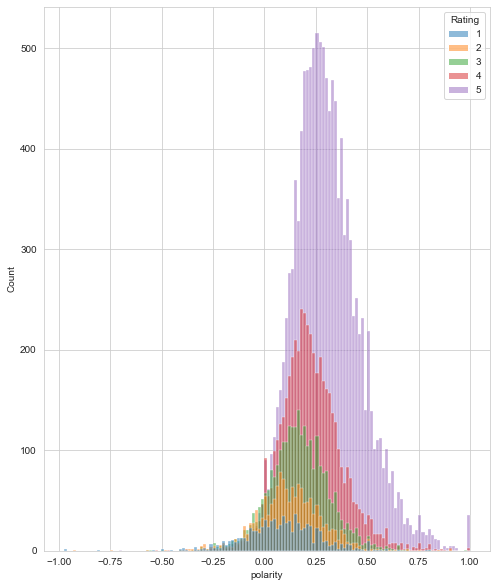

In [19]:
plt.figure(figsize = (8,10))
ax = sns.histplot(test, x = 'polarity',hue="Rating")
figure = ax.get_figure() 
figure.savefig('polarity.png', dpi=500)

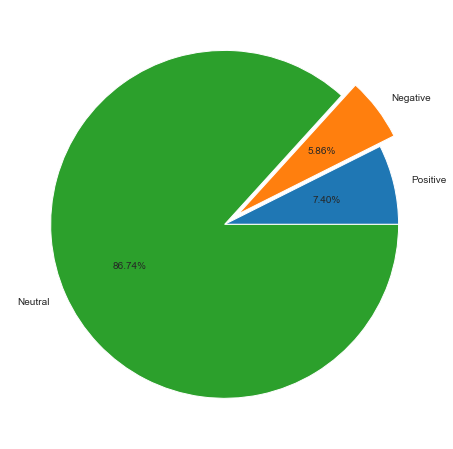

In [20]:
df = test
negative = (len(df.loc[df.polarity < 0, ['Review Text']].values)/len(df))*100
positive = (len(df.loc[df.polarity > 0.5, ['Review Text']].values)/len(df))*100
neutral = len(df.loc[df.polarity >0 ,['Review Text']].values) - len(df.loc[df.polarity >0.5 ,['Review Text']].values)
neutral = neutral/len(df)*100
plt.figure(figsize =(8, 8)) 
plt.pie([positive,negative,neutral], labels = ['Positive','Negative','Neutral'],shadow = False, autopct='%2.2f%%',explode = (0, 0.1, 0)) 
plt.savefig('Percentage.jpg', dpi=500)

## Text representation

### 3.1 One-hot encoding

In [21]:
# train_vec=np.concatenate([np.array(train_vec),df_train["Recommended IND"].to_numpy().reshape(len(train_vec),1)],axis=1)
def one_hot_encoding(df):
    X_train,X_test,y_train,y_test=train_test_split(df[["Review Text_processed"]],df["Rating"],test_size=0.2,random_state=123)
    cv = CountVectorizer(binary=True,min_df=1,max_df=17448)
    cv.fit(X_train["Review Text_processed"])
    X_train_encoding=cv.transform(X_train["Review Text_processed"])
    X_train_encoding=pd.DataFrame(X_train_encoding.A, columns=cv.get_feature_names(),index=X_train.index)
    X_test_encoding=cv.transform(X_test["Review Text_processed"])
    X_test_encoding=pd.DataFrame(X_test_encoding.A, columns=cv.get_feature_names(),index=X_test.index)
    
    return X_train_encoding,X_test_encoding,y_train,y_test

In [22]:
X_train_oh,X_test_oh,y_train_oh,y_test_oh=one_hot_encoding(df_lf)
X_train_oh.head()

,aa,ab,abdomen,abil,abl,absolut,abstract,abt,abund,ac,...,yoke,young,younger,yr,yummi,zero,zip,zipper,zone,zoom
10365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2579,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4121,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5440,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 3.2 TF-IDF

In [23]:
def tf_vectorization(df):
    X_train,X_test,y_train,y_test=train_test_split(df[["Review Text_processed"]],df["Rating"],test_size=0.2,random_state=123)
    tfidf = TfidfVectorizer(
        strip_accents=None,
        lowercase=True,
        preprocessor=None,  # applied preprocessor in Data Cleaning
        tokenizer=None,
        use_idf=True,
        norm="l2",
        smooth_idf=True,
        min_df=2,
    ).fit(X_train["Review Text_processed"])
    X_train_encoding=tfidf.transform(X_train["Review Text_processed"])
    X_train_encoding=pd.DataFrame(X_train_encoding.A, columns=tfidf.get_feature_names(),index=X_train.index)
    X_test_encoding=tfidf.transform(X_test["Review Text_processed"])
    X_test_encoding=pd.DataFrame(X_test_encoding.A, columns=tfidf.get_feature_names(),index=X_test.index)
    
    return X_train_encoding,X_test_encoding,y_train,y_test

In [24]:
X_train_tf,X_test_tf,y_train_tf,y_test_tf=tf_vectorization(df_lf)
X_test_tf.shape

(4529, 3355)

### 3.3 Word embedding

In [25]:
def word2vec_prep(tagged_data):
#     tagged_data=[word_tokenize(_d) for i, _d in enumerate(df_train["Text_processed"])]
    word_counts=Counter(itertools.chain(*tagged_data)) #dict
#     vocabulary_inv=[x[0] for x in word_counts.most_common()]
#     vocabulary = {x: i for i, x in enumerate(vocabulary_inv)}
    return word_counts

def embedding_weights(vocabulary_inv,inp_data):
    model_name = "embedding"
    model_name = os.path.join(model_name)
    num_workers = 8  # Number of threads to run in parallel
    downsampling = 1e-3  # Downsample setting for frequent words
    sentences = [[vocabulary_inv[w] for w in s] for s in inp_data]
    size_features=200
    min_word_count=2
    context=5
    downsampling = 1e-3
    embedding_model = word2vec.Word2Vec(sentences, workers=num_workers,
                                        sg=0,
                                        size=size_features,
                                        min_count=min_word_count,
                                        window=context,
                                        sample=downsampling)
    embedding_model.init_sims(replace=True) #clean from RAM
    embedding_weights = np.zeros((len(vocabulary_inv), size_features))
    for i in range(len(vocabulary_inv)):
        word = vocabulary_inv[i]
        if word in embedding_model:
            embedding_weights[i] = embedding_model[word]
        else:
            embedding_weights[i] = np.random.uniform(-0.1, 0.1,size_features)
    
    return embedding_weights

def train_test_word2vec(tagged_train_data,tagged_test_data,weights,vocabulary):
    train_vec = []
    for doc in tagged_train_data:
        vec = 0
        for w in doc:
            vec += weights[vocabulary[w]]
        vec = vec / len(doc)
        train_vec.append(vec)

    test_vec = []
    for doc in tagged_test_data:
        vec = 0
        length = 0
        for w in doc:
            try:
                vec += weights[vocabulary[w]]
                length += 1
            except:
                continue
        vec = vec / length
        test_vec.append(vec)
    
    return np.array(train_vec), np.array(test_vec)


def word_embedding(df):

    df_train,df_test=train_test_split(df,test_size=0.2,shuffle=True)
    tagged_data=[word_tokenize(_d) for i, _d in enumerate(df_train["Review Text_processed"])]
    word_counts=Counter(itertools.chain(*tagged_data))
    vocabulary_inv=[x[0] for x in word_counts.most_common()]
    vocabulary = {x: i for i, x in enumerate(vocabulary_inv)}
    inp_data = [[vocabulary[word] for word in text] for text in tagged_data]
    
    print("------generating weights------")
    weights=embedding_weights(vocabulary_inv,inp_data)
    
    tagged_train_data = [word_tokenize(_d) for i, _d in enumerate(df_train["Review Text_processed"])]
    tagged_test_data = [word_tokenize(_d) for i, _d in enumerate(df_test["Review Text_processed"])]
    print("------generating train/test dataset------")
    train_vec,test_vec=train_test_word2vec(tagged_train_data,tagged_test_data,weights,vocabulary)
#     train_vec=np.concatenate([train_vec,df_train["Recommended IND"].to_numpy().reshape(len(train_vec),1)],axis=1)
#     test_vec=np.concatenate([test_vec,df_test["Recommended IND"].to_numpy().reshape(len(test_vec),1)],axis=1)
    
    return train_vec,test_vec,df_train.Rating,df_test.Rating

In [26]:
X_train_we,X_test_we,y_train_we,y_test_we=word_embedding(df_lf)

------generating weights------
------generating train/test dataset------


## Sentiment Analysis Model 

### BernoulliNB with Bag of words

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
count = CountVectorizer()
X_count = count.fit_transform(reviews["Review Text_processed"]).toarray()
y=reviews['Recommended IND']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_count, y, test_size = 0.20, random_state = 0)

In [29]:
from sklearn.naive_bayes import BernoulliNB
classifier = BernoulliNB()
classifier.fit(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [30]:
y_pred = classifier.predict(X_test)
y_train_pred = classifier.predict(X_train)
from sklearn.metrics import accuracy_score
from sklearn import metrics
acc1 = accuracy_score(y_test, y_pred)
score = accuracy_score(y_train,y_train_pred)
score
print("Accuracy of the classifier using Bag of words: ",acc1)
print("Confusion matrix is :\n",metrics.confusion_matrix(y_test,y_pred))
print("Classification report: \n" ,metrics.classification_report(y_test,y_pred))

Accuracy of the classifier using Bag of words:  0.8743652020313535
Confusion matrix is :
 [[ 625  252]
 [ 317 3335]]
Classification report: 
              precision    recall  f1-score   support

          0       0.66      0.71      0.69       877
          1       0.93      0.91      0.92      3652

avg / total       0.88      0.87      0.88      4529



In [31]:
score

0.8894655477031802

### Logistic Regression with Bag of Words

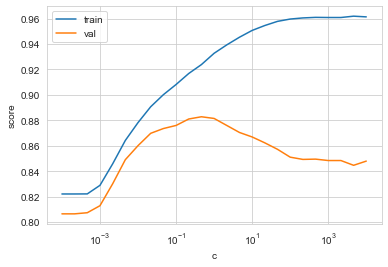

Best of c for the model is about  0.46415888336127775


In [32]:
res_train = []
res_test = []
c_range = np.logspace(-4,4,25)
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
for cc in c_range:
    clf = LogisticRegression(random_state = 42, C=cc, penalty='l2',solver='liblinear').fit(X_train, y_train)
    res_train.append(clf.score(X_train,y_train))
    res_test.append(clf.score(X_test,y_test))


plt.semilogx(c_range,res_train,label='train')
plt.semilogx(c_range,res_test,label='val')
plt.xlabel('c')
plt.ylabel('score')
plt.legend()
plt.show()
print(f'Best of c for the model is about ',[x for _,x in sorted(zip(res_test,c_range))][-1])

In [33]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state = 42, C=0.46, penalty='l2',solver='liblinear').fit(X_train, y_train)
print(clf.score(X_train,y_train))
print(clf.score(X_test,y_test))
y_pred = clf.predict(X_test)
acc2 = accuracy_score(y_test, y_pred)

0.9237522084805654
0.8827555751821594


In [34]:
print("Accuracy of the LogisticRegression using Bag of words: ",acc2)
print("Confusion matrix is :\n",metrics.confusion_matrix(y_test,y_pred))
print("Classification report: \n" ,metrics.classification_report(y_test,y_pred))

Accuracy of the LogisticRegression using Bag of words:  0.8827555751821594
Confusion matrix is :
 [[ 502  375]
 [ 156 3496]]
Classification report: 
              precision    recall  f1-score   support

          0       0.76      0.57      0.65       877
          1       0.90      0.96      0.93      3652

avg / total       0.88      0.88      0.88      4529



### Random Forest with Bag of Words

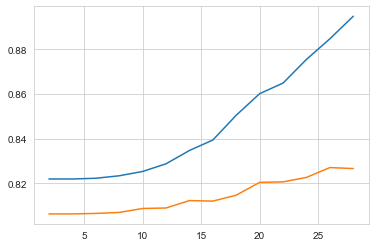

In [35]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
depth_list = np.arange(2,30,2)
acc_train, acc_test = [], []
for dp in depth_list:
    
    clf = RandomForestClassifier(max_depth=dp,random_state=0).fit(X_train,y_train)
    acc_train.append(np.sum(clf.predict(X_train)==y_train)/len(X_train))
    acc_test.append(np.sum(clf.predict(X_test)==y_test)/len(X_test))
    
plt.plot(depth_list,acc_train)
plt.plot(depth_list,acc_test)
plt.show()

In [36]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=26,random_state=0).fit(X_train,y_train)
print(np.sum(clf.predict(X_train)==y_train)/len(X_train))
print(np.sum(clf.predict(X_test)==y_test)/len(X_test))

y_pred = clf.predict(X_test)
acc3 = accuracy_score(y_test, y_pred)

0.8847725265017667
0.8271141532347096


In [37]:
print("Accuracy of the Random Forest using Bag of words: ",acc3)
print("Confusion matrix is :\n",metrics.confusion_matrix(y_test,y_pred))
print("Classification report: \n" ,metrics.classification_report(y_test,y_pred))

Accuracy of the Random Forest using Bag of words:  0.8271141532347096
Confusion matrix is :
 [[ 115  762]
 [  21 3631]]
Classification report: 
              precision    recall  f1-score   support

          0       0.85      0.13      0.23       877
          1       0.83      0.99      0.90      3652

avg / total       0.83      0.83      0.77      4529



### Linear SVC with Bag of Words

In [38]:
## Final method
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
clf = make_pipeline(StandardScaler(),LinearSVC(random_state=0, tol=1e-4,C=0.0001)).fit(X_train,y_train)

#clf = LogisticRegression(max_iter=100000000).fit(train_cat_vec, df_train["label"])

print(np.sum(clf.predict(X_train)==y_train)/len(X_train))
print(np.sum(clf.predict(X_test)==y_test)/len(X_test))

0.9260159010600707
0.870611614042835


In [39]:
clf = make_pipeline(StandardScaler(),LinearSVC(random_state=0, tol=1e-4,C=0.00001)).fit(X_train,y_train)

#clf = LogisticRegression(max_iter=100000000).fit(train_cat_vec, df_train["label"])

print(np.sum(clf.predict(X_train)==y_train)/len(X_train))
print(np.sum(clf.predict(X_test)==y_test)/len(X_test))

0.9022195229681979
0.8703908147493928


In [40]:
y_pred = clf.predict(X_test)
acc4 = accuracy_score(y_test, y_pred)
print("Accuracy of the LinearSVC using Bag of words: ",acc4)
print("Confusion matrix is :\n",metrics.confusion_matrix(y_test,y_pred))
print("Classification report: \n" ,metrics.classification_report(y_test,y_pred))

Accuracy of the LinearSVC using Bag of words:  0.8703908147493928
Confusion matrix is :
 [[ 635  242]
 [ 345 3307]]
Classification report: 
              precision    recall  f1-score   support

          0       0.65      0.72      0.68       877
          1       0.93      0.91      0.92      3652

avg / total       0.88      0.87      0.87      4529



### Multinomial NB with TF-IDF

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
tfidf = TfidfVectorizer(max_features = 5000,ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(reviews["Review Text_processed"]).toarray()


In [42]:
from sklearn import feature_selection

y=reviews['Recommended IND']
X_names = tfidf.get_feature_names()
p_value_limit = 0.997 # 3 sigma cutoff
df_features = pd.DataFrame()

for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_tfidf, y==cat)
    df_features = df_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "label":cat}))
    df_features = df_features.sort_values(["label","score"], 
                    ascending=[True,False])
    df_features = df_features[df_features["score"]>p_value_limit]
    
X_names = df_features["feature"].unique().tolist()
print(len(X_names))

238


In [43]:

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size = 0.20, random_state = 0)

In [44]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [45]:
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [46]:
y_pred = classifier.predict(X_test)
y_train_pred = classifier.predict(X_train)
acc5 = accuracy_score(y_test, y_pred)
score = accuracy_score(y_train,y_train_pred)

In [47]:
score

0.8849381625441696

In [48]:
print("Accuracy of the classifier using TF-IDF: ",acc5)
print("Confusion matrix is :\n",metrics.confusion_matrix(y_test,y_pred))
print("Classification report: \n" ,metrics.classification_report(y_test,y_pred))

Accuracy of the classifier using TF-IDF:  0.8593508500772797
Confusion matrix is :
 [[ 289  588]
 [  49 3603]]
Classification report: 
              precision    recall  f1-score   support

          0       0.86      0.33      0.48       877
          1       0.86      0.99      0.92      3652

avg / total       0.86      0.86      0.83      4529



### Logistic Regression with TF-IDF

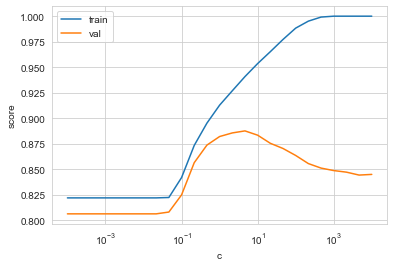

Best of c for the model is about  4.641588833612772


In [49]:
res_train = []
res_test = []
c_range = np.logspace(-4,4,25)
import matplotlib.pyplot as plt
import numpy as np

for cc in c_range:
    clf = LogisticRegression(random_state = 42, C=cc, penalty='l2',solver='liblinear').fit(X_train, y_train)
    res_train.append(clf.score(X_train,y_train))
    res_test.append(clf.score(X_test,y_test))


plt.semilogx(c_range,res_train,label='train')
plt.semilogx(c_range,res_test,label='val')
plt.xlabel('c')
plt.ylabel('score')
plt.legend()
plt.show()
print(f'Best of c for the model is about ',[x for _,x in sorted(zip(res_test,c_range))][-1])

In [52]:
clf = LogisticRegression(random_state = 42, C=4.64, penalty='l2',solver='liblinear').fit(X_train, y_train)
print(clf.score(X_train,y_train))
print(clf.score(X_test,y_test))
y_pred = clf.predict(X_test)
acc6 = accuracy_score(y_test, y_pred)

0.9408679328621908
0.8876131596378891


In [53]:
print("Accuracy of the LogisticRegression using TF-IDF: ",acc6)
print("Confusion matrix is :\n",metrics.confusion_matrix(y_test,y_pred))
print("Classification report: \n" ,metrics.classification_report(y_test,y_pred))

Accuracy of the LogisticRegression using TF-IDF:  0.8876131596378891
Confusion matrix is :
 [[ 515  362]
 [ 147 3505]]
Classification report: 
              precision    recall  f1-score   support

          0       0.78      0.59      0.67       877
          1       0.91      0.96      0.93      3652

avg / total       0.88      0.89      0.88      4529



### Random Forest with TF-IDF

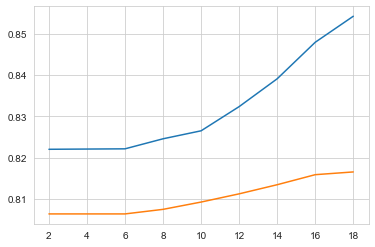

In [54]:
import matplotlib.pyplot as plt
depth_list = np.arange(2,20,2)
acc_train, acc_test = [], []
for dp in depth_list:
    
    clf = RandomForestClassifier(max_depth=dp,random_state=0).fit(X_train,y_train)
    acc_train.append(np.sum(clf.predict(X_train)==y_train)/len(X_train))
    acc_test.append(np.sum(clf.predict(X_test)==y_test)/len(X_test))
    
plt.plot(depth_list,acc_train)
plt.plot(depth_list,acc_test)
plt.show()

In [55]:
clf = RandomForestClassifier(max_depth=20,random_state=0).fit(X_train,y_train)
print(clf.score(X_train,y_train))
print(clf.score(X_test,y_test))
y_pred = clf.predict(X_test)
acc7 = accuracy_score(y_test, y_pred)
print("Accuracy of the Random Forest using TF-IDF: ",acc7)
print("Confusion matrix is :\n",metrics.confusion_matrix(y_test,y_pred))
print("Classification report: \n" ,metrics.classification_report(y_test,y_pred))

0.8646201413427562
0.8222565687789799
Accuracy of the Random Forest using TF-IDF:  0.8222565687789799
Confusion matrix is :
 [[  94  783]
 [  22 3630]]
Classification report: 
              precision    recall  f1-score   support

          0       0.81      0.11      0.19       877
          1       0.82      0.99      0.90      3652

avg / total       0.82      0.82      0.76      4529



### Linear SVC with TF-IDF

In [56]:
## Final method
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
clf = make_pipeline(StandardScaler(),LinearSVC(random_state=0, tol=1e-4,C=0.0001)).fit(X_train,y_train)

#clf = LogisticRegression(max_iter=100000000).fit(train_cat_vec, df_train["label"])

print(np.sum(clf.predict(X_train)==y_train)/len(X_train))
print(np.sum(clf.predict(X_test)==y_test)/len(X_test))

0.9479902826855123
0.8827555751821594


In [57]:
y_pred = clf.predict(X_test)
acc8 = accuracy_score(y_test, y_pred)
print("Accuracy of the LinearSVC using TF-IDF: ",acc8)
print("Confusion matrix is :\n",metrics.confusion_matrix(y_test,y_pred))
print("Classification report: \n" ,metrics.classification_report(y_test,y_pred))

Accuracy of the LinearSVC using TF-IDF:  0.8827555751821594
Confusion matrix is :
 [[ 580  297]
 [ 234 3418]]
Classification report: 
              precision    recall  f1-score   support

          0       0.71      0.66      0.69       877
          1       0.92      0.94      0.93      3652

avg / total       0.88      0.88      0.88      4529



### word2vec

In [58]:
import multiprocessing

from gensim.models import Word2Vec

w2v_model = Word2Vec()
w2v_model.build_vocab(reviews["Review Text_processed"], progress_per=10000)

w2v_model.train(reviews["Review Text_processed"], total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

w2v_model.init_sims(replace=True)

In [59]:
import numpy as np
from numpy import dot
from numpy.linalg import norm
def document_vector_w2v(doc):
    """Create document vectors by averaging word vectors. Remove out-of-vocabulary words."""
    doc = [word for word in doc if word in w2v_model.wv.vocab]
    return np.mean(w2v_model[doc], axis=0)

In [60]:
X_w2v=reviews["Review Text_processed"].apply(lambda x: ' '.join(x)).apply(document_vector_w2v)
y_w2v = reviews['Recommended IND']

In [61]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_w2v, y_w2v, test_size = 0.20, random_state = 0)

In [62]:
X_train, X_test, y_train, y_test = list(X_train), list(X_test), list(y_train), list(y_test)


### Logistic Regression with word2vec

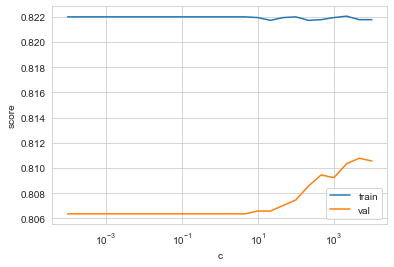

Best of c for the model is about  4641.588833612773


In [63]:
res_train = []
res_test = []
c_range = np.logspace(-4,4,25)
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
for cc in c_range:
    clf = LogisticRegression(random_state = 42, C=cc, penalty='l2',solver='liblinear').fit(X_train, y_train)
    res_train.append(clf.score(X_train,y_train))
    res_test.append(clf.score(X_test,y_test))


plt.semilogx(c_range,res_train,label='train')
plt.semilogx(c_range,res_test,label='val')
plt.xlabel('c')
plt.ylabel('score')
plt.legend()
plt.show()
print(f'Best of c for the model is about ',[x for _,x in sorted(zip(res_test,c_range))][-1])

In [66]:
from sklearn.metrics import accuracy_score
from sklearn import metrics
clf = LogisticRegression(random_state = 42, C=1000, penalty='l2',solver='liblinear').fit(X_train, y_train)
print(clf.score(X_train,y_train))
print(clf.score(X_test,y_test))
y_pred = clf.predict(X_test)
acc9 = accuracy_score(y_test, y_pred)

0.8219412544169611
0.8092294104658865


In [67]:
print("Accuracy of the LogisticRegression using word2vec: ",acc9)
print("Confusion matrix is :\n",metrics.confusion_matrix(y_test,y_pred))
print("Classification report: \n" ,metrics.classification_report(y_test,y_pred))

Accuracy of the LogisticRegression using word2vec:  0.8092294104658865
Confusion matrix is :
 [[  29  848]
 [  16 3636]]
Classification report: 
              precision    recall  f1-score   support

          0       0.64      0.03      0.06       877
          1       0.81      1.00      0.89      3652

avg / total       0.78      0.81      0.73      4529



### Random Forest with word2vec

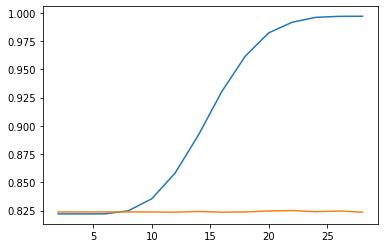

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
depth_list = np.arange(2,30,2)
acc_train, acc_test = [], []
for dp in depth_list:
    
    clf = RandomForestClassifier(max_depth=dp,random_state=0).fit(X_train,y_train)
    acc_train.append(np.sum(clf.predict(X_train)==y_train)/len(X_train))
    acc_test.append(np.sum(clf.predict(X_test)==y_test)/len(X_test))
    
plt.plot(depth_list,acc_train)
plt.plot(depth_list,acc_test)
plt.show()

In [68]:
clf = RandomForestClassifier(max_depth=20,random_state=0).fit(X_train,y_train)
print(clf.score(X_train,y_train))
print(clf.score(X_test,y_test))
y_pred = clf.predict(X_test)
acc10 = accuracy_score(y_test, y_pred)
print("Accuracy of the Random Forest using word2vec: ",acc10)
print("Confusion matrix is :\n",metrics.confusion_matrix(y_test,y_pred))
print("Classification report: \n" ,metrics.classification_report(y_test,y_pred))

0.969357332155477
0.7895782733495252
Accuracy of the Random Forest using word2vec:  0.7895782733495252
Confusion matrix is :
 [[  68  809]
 [ 144 3508]]
Classification report: 
              precision    recall  f1-score   support

          0       0.32      0.08      0.12       877
          1       0.81      0.96      0.88      3652

avg / total       0.72      0.79      0.73      4529



### Linear SVC with word2vec

In [69]:
## Final method
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
clf = make_pipeline(StandardScaler(),LinearSVC(random_state=0, tol=1e-4,C=0.00001)).fit(X_train,y_train)

#clf = LogisticRegression(max_iter=100000000).fit(train_cat_vec, df_train["label"])

print(np.sum(clf.predict(X_train)==y_train)/len(X_train))
print(np.sum(clf.predict(X_test)==y_test)/len(X_test))

0.8197327738515902
0.8061382203576949


In [70]:
y_pred = clf.predict(X_test)
acc11 = accuracy_score(y_test, y_pred)
print("Accuracy of the LinearSVC using word2vec: ",acc11)
print("Confusion matrix is :\n",metrics.confusion_matrix(y_test,y_pred))
print("Classification report: \n" ,metrics.classification_report(y_test,y_pred))

Accuracy of the LinearSVC using word2vec:  0.8061382203576949
Confusion matrix is :
 [[  47  830]
 [  48 3604]]
Classification report: 
              precision    recall  f1-score   support

          0       0.49      0.05      0.10       877
          1       0.81      0.99      0.89      3652

avg / total       0.75      0.81      0.74      4529



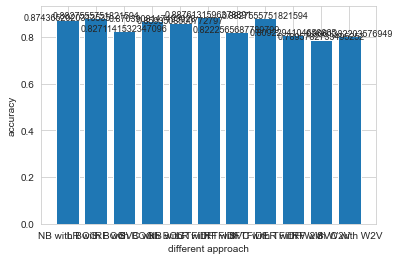

In [71]:
import matplotlib.pyplot as plt
index=['NB with BOG','LR with BOG','RF with BOG','SVC with BOG','NB with TFIDF','LR with TFIDF','RF with TFIDF','SVC with TFIDF','LR with W2V','RF with W2V','SVC with W2V']
acc = [acc1,acc2,acc3,acc4,acc5,acc6,acc7,acc8,acc9,acc10,acc11]
plt.bar(index,acc)
for index,value in enumerate(acc):
    plt.text(index,value, str(value),fontsize=9,horizontalalignment='center')
plt.ylabel('accuracy')
plt.xlabel('different approach')
plt.show()

In [72]:
index=['NB with BOG','LR with BOG','RF with BOG','SVC with BOG','NB with TFIDF','LR with TFIDF','RF with TFIDF','SVC with TFIDF','LR with W2V','RF with W2V','SVC with W2V']
acc = [acc1,acc2,acc3,acc4,acc5,acc6,acc7,acc8,acc9,acc10,acc11]
d = {'approach':index,'accuracy':acc}
df=pd.DataFrame(data=d)
df

,approach,accuracy
0,NB with BOG,0.874365
1,LR with BOG,0.882756
2,RF with BOG,0.827114
3,SVC with BOG,0.870391
4,NB with TFIDF,0.859351
5,LR with TFIDF,0.887613
6,RF with TFIDF,0.822257
7,SVC with TFIDF,0.882756
8,LR with W2V,0.809229
9,RF with W2V,0.789578


### Deep Learning

In [73]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [74]:
tokenizer = Tokenizer(num_words = 3000)
tokenizer.fit_on_texts(reviews["Review Text_processed"])

In [75]:
sequences = tokenizer.texts_to_sequences(reviews["Review Text_processed"])
padded = pad_sequences(sequences, padding='post')

In [76]:
word_index = tokenizer.word_index
count = 0
for i,j in word_index.items():
    if count == 11:
        break
    print(i,j)
    count = count+1

dress 1
fit 2
love 3
size 4
look 5
top 6
wear 7
like 8
color 9
would 10
great 11


In [77]:
embedding_dim = 64
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(3000, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          192000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 192,397
Trainable params: 192,397
Non-trainable params: 0
_________________________________________________________________


In [78]:
num_epochs = 10

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [79]:
model.fit(padded,y,epochs= num_epochs)

Epoch 1/10
708/708 [==============================] - 3s 4ms/step - loss: 0.4099 - accuracy: 0.8247
Epoch 2/10
708/708 [==============================] - 3s 4ms/step - loss: 0.2554 - accuracy: 0.8906
Epoch 3/10
708/708 [==============================] - 3s 4ms/step - loss: 0.2294 - accuracy: 0.9037
Epoch 4/10
708/708 [==============================] - 3s 4ms/step - loss: 0.2166 - accuracy: 0.9103
Epoch 5/10
708/708 [==============================] - 3s 4ms/step - loss: 0.2079 - accuracy: 0.9146
Epoch 6/10
708/708 [==============================] - 3s 4ms/step - loss: 0.2000 - accuracy: 0.9189
Epoch 7/10
708/708 [==============================] - 3s 4ms/step - loss: 0.1934 - accuracy: 0.9216
Epoch 8/10
708/708 [==============================] - 3s 4ms/step - loss: 0.1875 - accuracy: 0.9231
Epoch 9/10
708/708 [==============================] - 3s 4ms/step - loss: 0.1810 - accuracy: 0.9262
Epoch 10/10
708/708 [==============================] - 3s 4ms/step - loss: 0.1754 - accuracy: 0.9275

In [80]:
sample_string = "I Will tell my friends for sure"
sample = tokenizer.texts_to_sequences(sample_string)
padded_sample = pad_sequences(sample, padding='post')

In [81]:
padded_sample.T

array([], shape=(0, 31), dtype=int32)

## Rating Prediction Model
### Neural Network (Keras)

In [15]:
def NN_fit(X_train,y_train):
    model=Sequential()
    n_cols=X_train.shape[1]
    model.add(Dense(11,activation='relu',input_shape=(n_cols,)))
    model.add(Dense(11,activation='relu'))
#     model.add(Dense(20,activation='relu'))
#     model.add(Dense(20,activation='relu'))

    model.add(Dense(5,activation='softmax'))
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=["accuracy"])
    early_stopping_monitor=EarlyStopping(patience=3)
    model.fit(X_train,pd.get_dummies(y_train).to_numpy(),validation_split=0.2,epochs=100,callbacks=[early_stopping_monitor])
    
    return model

In [59]:
model_test=NN_fit(X_train_we,y_train_we)

Epoch 1/100
453/453 [==============================] - 1s 1ms/step - loss: 1.3091 - accuracy: 0.5473 - val_loss: 1.0176 - val_accuracy: 0.5904
Epoch 2/100
453/453 [==============================] - 0s 870us/step - loss: 1.0120 - accuracy: 0.5975 - val_loss: 0.9920 - val_accuracy: 0.5945
Epoch 3/100
453/453 [==============================] - 0s 944us/step - loss: 1.0046 - accuracy: 0.5898 - val_loss: 0.9819 - val_accuracy: 0.6050
Epoch 4/100
453/453 [==============================] - 0s 915us/step - loss: 0.9809 - accuracy: 0.5974 - val_loss: 0.9740 - val_accuracy: 0.6064
Epoch 5/100
453/453 [==============================] - 0s 923us/step - loss: 0.9772 - accuracy: 0.6048 - val_loss: 0.9687 - val_accuracy: 0.6072
Epoch 6/100
453/453 [==============================] - 0s 934us/step - loss: 0.9741 - accuracy: 0.6042 - val_loss: 0.9667 - val_accuracy: 0.6089
Epoch 7/100
453/453 [==============================] - 0s 883us/step - loss: 0.9861 - accuracy: 0.6005 - val_loss: 0.9609 - val_accu

In [63]:
np.unique(model_test.predict_classes(X_train_we))

array([0, 1, 2, 3, 4])

In [77]:
encoding_name=["One-hot+NN","TF-IDF+NN","Word_embedding+NN"]
data_pool=[[X_train_oh.to_numpy(),X_test_oh.to_numpy(),y_train_oh,y_test_oh],
           [X_train_tf.to_numpy(),X_test_tf.to_numpy(),y_train_tf,y_test_tf],
          [X_train_we,X_test_we,y_train_we,y_test_we]]

score_list=[]

for data in data_pool:
    clf=NN_fit(data[0],data[2])
    y_train_pred_nn=clf.predict_classes(data[0])+1
    y_test_pred_nn=clf.predict_classes(data[1])+1
#     train_score=clf.predict(data[0],pd.get_dummies(data[2]))[1]
#     test_score=clf.predict(data[1],pd.get_dummies(data[3]))[1]
    score_list.append([metrics.accuracy_score(data[2], y_train_pred_nn),
                      metrics.accuracy_score(data[3], y_test_pred_nn),
                     f1_score(data[2], y_train_pred_nn, average="macro"),
                       f1_score(data[3], y_test_pred_nn, average="macro")])
    
result_nn=pd.DataFrame(score_list,columns=["Train_acc","Test_acc","Train_f1","Test_f1"],index=encoding_name)
result_nn

Epoch 1/100
453/453 [==============================] - 1s 2ms/step - loss: 1.1646 - accuracy: 0.5546 - val_loss: 0.9048 - val_accuracy: 0.6335
Epoch 2/100
453/453 [==============================] - 1s 1ms/step - loss: 0.8308 - accuracy: 0.6567 - val_loss: 0.8895 - val_accuracy: 0.6332
Epoch 3/100
453/453 [==============================] - 1s 1ms/step - loss: 0.7435 - accuracy: 0.6954 - val_loss: 0.9008 - val_accuracy: 0.6296
Epoch 4/100
453/453 [==============================] - 1s 1ms/step - loss: 0.6621 - accuracy: 0.7345 - val_loss: 0.9335 - val_accuracy: 0.6174
Epoch 5/100
453/453 [==============================] - 1s 1ms/step - loss: 0.6154 - accuracy: 0.7598 - val_loss: 0.9643 - val_accuracy: 0.6119


/Users/yinuochen/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
453/453 [==============================] - 1s 1ms/step - loss: 1.3463 - accuracy: 0.5313 - val_loss: 0.9450 - val_accuracy: 0.6114
Epoch 2/100
453/453 [==============================] - 1s 1ms/step - loss: 0.8831 - accuracy: 0.6314 - val_loss: 0.8740 - val_accuracy: 0.6351
Epoch 3/100
453/453 [==============================] - 1s 1ms/step - loss: 0.7815 - accuracy: 0.6789 - val_loss: 0.8686 - val_accuracy: 0.6390
Epoch 4/100
453/453 [==============================] - 1s 1ms/step - loss: 0.7146 - accuracy: 0.7092 - val_loss: 0.8846 - val_accuracy: 0.6329
Epoch 5/100
453/453 [==============================] - 1s 1ms/step - loss: 0.6659 - accuracy: 0.7306 - val_loss: 0.9045 - val_accuracy: 0.6323
Epoch 6/100
453/453 [==============================] - 1s 1ms/step - loss: 0.6409 - accuracy: 0.7419 - val_loss: 0.9310 - val_accuracy: 0.6147
Epoch 1/100
453/453 [==============================] - 1s 1ms/step - loss: 1.3001 - accuracy: 0.5276 - val_loss: 1.0313 - val_accuracy: 0.5702

,Train_acc,Test_acc,Train_f1,Test_f1
One-hot+NN,0.755411,0.618238,0.636620,0.443728
TF-IDF+NN,0.741884,0.612497,0.621029,0.421230
Word_embedding+NN,0.613626,0.608302,0.356031,0.346883


### LinearSVC

In [88]:
# from sklearn import svm
# from sklearn import metrics

# clf = svm.SVC(kernel='linear')
# clf.fit(X_train_oh,y_train_oh)
# y_pred = clf.predict(X_test_oh)
# print("Accuracy:",metrics.accuracy_score(y_test_oh, y_pred))

In [50]:
start_time = time.time()
# print(start_time)
clf = OneVsRestClassifier(SVC(kernel='linear', probability=False), n_jobs=-1)
clf.fit(X_train_oh,y_train_oh)
y_train_pred_oh = clf.predict(X_train_oh)
y_test_pred_oh = clf.predict(X_test_oh)
end_time = time.time()
print("Completed")
print(round((end_time-start_time)/60,2))

Completed
100.05


In [22]:
score_list_svc=[]

In [ ]:
# score_list_svc=[]
score_list.append([metrics.accuracy_score(y_train_oh, y_train_pred_oh),
                   metrics.accuracy_score(y_test_oh, y_test_pred_oh),
                   f1_score(y_train_oh, y_train_pred_oh, average="macro"),     
                   f1_score(y_test_oh, y_test_pred_oh, average="macro"))

In [52]:
start_time = time.time()
clf = OneVsRestClassifier(SVC(kernel='linear', probability=False), n_jobs=-1)
clf.fit(X_train_tf,y_train_tf)
y_train_pred_tf = clf.predict(X_train_tf)
y_test_pred_tf = clf.predict(X_test_tf)
end_time = time.time()
print("Completed")
print(round((end_time-start_time)/60,2))

Completed
58.17


In [17]:
start_time = time.time()
clf = OneVsRestClassifier(SVC(kernel='linear', probability=False), n_jobs=-1)
clf.fit(X_train_we,y_train_we)
y_train_pred_we = clf.predict(X_train_we)
y_test_pred_we = clf.predict(X_test_we)
end_time = time.time()
print("Completed")
print(round(end_time-start_time,2))

Completed
194.55


In [57]:
score_list_svc=[]
score_list_svc=[[metrics.accuracy_score(y_train_oh, y_train_pred_oh),
                   metrics.accuracy_score(y_test_oh, y_test_pred_oh),
                   f1_score(y_train_oh, y_train_pred_oh, average="macro"),     
                   f1_score(y_test_oh, y_test_pred_oh, average="macro")],
                [metrics.accuracy_score(y_train_tf, y_train_pred_tf),
                   metrics.accuracy_score(y_test_tf, y_test_pred_tf),
                   f1_score(y_train_tf, y_train_pred_tf, average="macro"),     
                   f1_score(y_test_tf, y_test_pred_tf, average="macro")],
                [metrics.accuracy_score(y_train_we, y_train_pred_we),
                   metrics.accuracy_score(y_test_we, y_test_pred_we),
                   f1_score(y_train_we, y_train_pred_we, average="macro"),     
                   f1_score(y_test_we, y_test_pred_we, average="macro")]
               ]
result_svc=pd.DataFrame(score_list_svc,columns=["Train_acc","Test_acc","Train_f1","Test_f1"],index=encoding_name)
result_svc

,Train_acc,Test_acc,Train_f1,Test_f1
One-hot+SVC,0.794335,0.612056,0.745194,0.403464
TF-IDF+SVC,0.733271,0.627512,0.647086,0.383204
Word_embedding+SVC,0.598222,0.592184,0.317670,0.300082


## Feature selection

In [26]:
from sklearn import feature_selection
X_names=X_train_tf.columns
p_value_limit = 0.997
df_features = pd.DataFrame()

for cat in np.unique(y_train_tf):
    chi2, p = feature_selection.chi2(X_train_tf, y_train_tf==cat)
    df_features = df_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "label":cat}))
    df_features = df_features.sort_values(["label","score"], 
                    ascending=[True,False])
    df_features = df_features[df_features["score"]>p_value_limit]

In [27]:
X_train_tf_fs=X_train_tf.loc[:,df_features.feature.unique()]
X_test_tf_fs=X_test_tf.loc[:,df_features.feature.unique()]

In [28]:
X_train_tf_fs.shape

(18112, 206)

In [29]:
X_names=X_train_oh.columns
p_value_limit = 0.997
df_features = pd.DataFrame()

for cat in np.unique(y_train_oh):
    chi2, p = feature_selection.chi2(X_train_oh, y_train_oh==cat)
    df_features = df_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "label":cat}))
    df_features = df_features.sort_values(["label","score"], 
                    ascending=[True,False])
    df_features = df_features[df_features["score"]>p_value_limit]
    
for cat in np.unique(y_train_oh):
   print("# {}:".format(cat))
   print("  . selected features:",len(df_features[df_features["label"]==cat]))
   print("  . top features:", ",".join(df_features[df_features["label"]==cat]["feature"].values[:10]))
   print(" ")

# 1:
  . selected features: 285
  . top features: aw,cheap,disappoint,disintegr,excit,hideou,horribl,huge,mess,money
 
# 2:
  . selected features: 281
  . top features: back,bad,cheap,comfort,disappoint,great,huge,model,perfect,return
 
# 3:
  . selected features: 315
  . top features: back,bad,comfort,compliment,disappoint,excit,great,howev,jean,much
 
# 4:
  . selected features: 137
  . top features: bit,complaint,keep,littl,run,star,perfect,though,overal,nice
 
# 5:
  . selected features: 577
  . top features: absolut,amaz,area,arm,awkward,back,bad,beauti,big,boot
 


In [31]:
X_train_oh_fs=X_train_oh.loc[:,df_features.feature.unique()]
X_test_oh_fs=X_test_oh.loc[:,df_features.feature.unique()]

In [32]:
X_train_oh_fs.shape

(18112, 836)

### Retain on Neural Network (Keras)

In [72]:
encoding_name=["One-hot+NN+FS","TF-IDF+NN+FS"]
data_pool=[[X_train_oh_fs.to_numpy(),X_test_oh_fs.to_numpy(),y_train_oh,y_test_oh],
           [X_train_tf_fs.to_numpy(),X_test_tf_fs.to_numpy(),y_train_tf,y_test_tf]]

score_list=[]

for data in data_pool:
    clf=NN_fit(data[0],data[2])
#     train_score=clf.evaluate(data[0],pd.get_dummies(data[2]))[1]
#     test_score=clf.evaluate(data[1],pd.get_dummies(data[3]))[1]
#     score_list.append([train_score,test_score])
    y_train_pred_nn=clf.predict_classes(data[0])+1
    y_test_pred_nn=clf.predict_classes(data[1])+1
    score_list.append([metrics.accuracy_score(data[2], y_train_pred_nn),
                      metrics.accuracy_score(data[3], y_test_pred_nn),
                     f1_score(data[2], y_train_pred_nn, average="macro"),
                       f1_score(data[3], y_test_pred_nn, average="macro")])
    
result_nn_fs=pd.DataFrame(score_list,columns=["Train_acc","Test_acc","Train_f1","Test_f1"],index=encoding_name)
result_nn_fs

Epoch 1/100
453/453 [==============================] - 1s 1ms/step - loss: 1.2319 - accuracy: 0.5268 - val_loss: 0.9058 - val_accuracy: 0.6243
Epoch 2/100
453/453 [==============================] - 0s 1ms/step - loss: 0.8731 - accuracy: 0.6374 - val_loss: 0.8751 - val_accuracy: 0.6392
Epoch 3/100
453/453 [==============================] - 0s 1ms/step - loss: 0.8075 - accuracy: 0.6687 - val_loss: 0.8736 - val_accuracy: 0.6420
Epoch 4/100
453/453 [==============================] - 0s 987us/step - loss: 0.8011 - accuracy: 0.6699 - val_loss: 0.8764 - val_accuracy: 0.6404
Epoch 5/100
453/453 [==============================] - 0s 978us/step - loss: 0.7722 - accuracy: 0.6856 - val_loss: 0.8771 - val_accuracy: 0.6420
Epoch 6/100
453/453 [==============================] - 0s 980us/step - loss: 0.7500 - accuracy: 0.7001 - val_loss: 0.8857 - val_accuracy: 0.6409
Epoch 1/100
453/453 [==============================] - 1s 1ms/step - loss: 1.4440 - accuracy: 0.5028 - val_loss: 1.0281 - val_accuracy: 

,Train_acc,Test_acc,Train_f1,Test_f1
One-hot+NN+FS,0.698929,0.631486,0.545134,0.417691
TF-IDF+NN+FS,0.643883,0.619121,0.458443,0.402997


### Retrain on linear SVC

In [41]:
score_list_svc_fs=[]

In [42]:
start_time = time.time()
clf = OneVsRestClassifier(SVC(kernel='linear', probability=False), n_jobs=-1)
clf.fit(X_train_oh_fs,y_train_oh)
y_train_pred_oh_fs = clf.predict(X_train_oh_fs)
y_test_pred_oh_fs = clf.predict(X_test_oh_fs)
end_time = time.time()
print("Completed")
print(round(end_time-start_time,2))

Completed
1753.59


In [43]:
score_list_svc_fs.append([metrics.accuracy_score(y_train_oh, y_train_pred_oh_fs),
                   metrics.accuracy_score(y_test_oh, y_test_pred_oh_fs),
                   f1_score(y_train_oh, y_train_pred_oh_fs, average="macro"),     
                   f1_score(y_test_oh, y_test_pred_oh_fs, average="macro")])

In [44]:
clf = OneVsRestClassifier(SVC(kernel='linear', probability=False), n_jobs=-1)
clf.fit(X_train_tf_fs,y_train_tf)
y_train_pred_tf_fs = clf.predict(X_train_tf_fs)
y_test_pred_tf_fs = clf.predict(X_test_tf_fs)

In [45]:
# score_list_svc=[]
score_list_svc_fs.append([metrics.accuracy_score(y_train_tf, y_train_pred_tf_fs),
                   metrics.accuracy_score(y_test_tf, y_test_pred_tf_fs),
                   f1_score(y_train_tf, y_train_pred_tf_fs, average="macro"),     
                   f1_score(y_test_tf, y_test_pred_tf_fs, average="macro")])

In [75]:
result_svc_fs=pd.DataFrame(score_list_svc_fs,columns=["Train_acc","Test_acc","Train_f1","Test_f1"],index=["One-hot+SVC+FS","TF-IDF+SVC+FS"])
result_svc_fs

,Train_acc,Test_acc,Train_f1,Test_f1
One-hot+SVC+FS,0.676734,0.609848,0.533671,0.366183
TF-IDF+SVC+FS,0.615007,0.603444,0.380943,0.321392


In [81]:
result_nn.append(result_svc).round(4)

,Train_acc,Test_acc,Train_f1,Test_f1
One-hot+NN,0.7554,0.6182,0.6366,0.4437
TF-IDF+NN,0.7419,0.6125,0.6210,0.4212
Word_embedding+NN,0.6136,0.6083,0.3560,0.3469
One-hot+SVC,0.7943,0.6121,0.7452,0.4035
TF-IDF+SVC,0.7333,0.6275,0.6471,0.3832
Word_embedding+SVC,0.5982,0.5922,0.3177,0.3001


In [84]:
result_nn_fs.append(result_svc_fs).round(4)

,Train_acc,Test_acc,Train_f1,Test_f1
One-hot+NN+FS,0.6989,0.6315,0.5451,0.4177
TF-IDF+NN+FS,0.6439,0.6191,0.4584,0.4030
One-hot+SVC+FS,0.6767,0.6098,0.5337,0.3662
TF-IDF+SVC+FS,0.6150,0.6034,0.3809,0.3214


In [83]:
result_nn.append(result_svc).append(result_svc_fs).append(result_nn_fs).round(4)

,Train_acc,Test_acc,Train_f1,Test_f1
One-hot+NN,0.7554,0.6182,0.6366,0.4437
TF-IDF+NN,0.7419,0.6125,0.6210,0.4212
Word_embedding+NN,0.6136,0.6083,0.3560,0.3469
One-hot+SVC,0.7943,0.6121,0.7452,0.4035
TF-IDF+SVC,0.7333,0.6275,0.6471,0.3832
Word_embedding+SVC,0.5982,0.5922,0.3177,0.3001
One-hot+SVC+FS,0.6767,0.6098,0.5337,0.3662
TF-IDF+SVC+FS,0.6150,0.6034,0.3809,0.3214
One-hot+NN+FS,0.6989,0.6315,0.5451,0.4177
TF-IDF+NN+FS,0.6439,0.6191,0.4584,0.4030


## Recommender System

In [82]:
reviews=pd.read_csv("data/Womens Clothing E-Commerce Reviews.csv")
df = reviews

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
Unnamed: 0                 23486 non-null int64
Clothing ID                23486 non-null int64
Age                        23486 non-null int64
Title                      19676 non-null object
Review Text                22641 non-null object
Rating                     23486 non-null int64
Recommended IND            23486 non-null int64
Positive Feedback Count    23486 non-null int64
Division Name              23472 non-null object
Department Name            23472 non-null object
Class Name                 23472 non-null object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [84]:
df[df['Division Name'].isnull()]

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
9444,9444,72,25,My favorite socks!!!,"I never write reviews, but these socks are so ...",5,1,0,NaN,NaN,NaN
13767,13767,492,23,So soft!,I just love this hoodie! it is so soft and com...,5,1,1,NaN,NaN,NaN
13768,13768,492,49,Wardrobe staple,Love this hoodie. so soft and goes with everyt...,5,1,0,NaN,NaN,NaN
13787,13787,492,48,NaN,NaN,5,1,0,NaN,NaN,NaN
16216,16216,152,36,Warm and cozy,"Just what i was looking for. soft, cozy and warm.",5,1,0,NaN,NaN,NaN
16221,16221,152,37,Love!,I am loving these. they are quite long but are...,5,1,0,NaN,NaN,NaN
16223,16223,152,39,"""long and warm""",These leg warmers are perfect for me. they are...,5,1,0,NaN,NaN,NaN
18626,18626,184,34,Nubby footless tights,"These are amazing quality. i agree, size up to...",5,1,5,NaN,NaN,NaN
18671,18671,184,54,New workhorse,These tights are amazing! if i care for them w...,5,1,0,NaN,NaN,NaN
20088,20088,772,50,Comfy sweatshirt!,This sweatshirt is really nice! it's oversize...,5,1,0,NaN,NaN,NaN


In [85]:
df_filter = df.dropna(subset = ['Division Name','Department Name', 'Class Name'])

In [86]:
df_filter.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [87]:
bins = [18, 30, 40, 50, 60, 70, 120]
labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70+']
df_filter['Age_group'] = pd.cut(df_filter.Age, bins, labels=labels, include_lowest = True, right = False)

In [88]:
df_filter['Group_rating'] = df_filter.groupby(['Clothing ID','Age_group'])[['Rating']].transform('mean')

In [89]:
df_filter['Group_recommend_prop'] = df_filter.groupby(['Clothing ID','Age_group'])[['Recommended IND']].transform('mean')

In [90]:
Age_groups = pd.get_dummies(df_filter.Age_group)
Age_groups[:10]

Age_group,18-29,30-39,40-49,50-59,60-69,70+
0,0,1,0,0,0,0
1,0,1,0,0,0,0
2,0,0,0,0,1,0
3,0,0,0,1,0,0
4,0,0,1,0,0,0
5,0,0,1,0,0,0
6,0,1,0,0,0,0
7,0,1,0,0,0,0
8,1,0,0,0,0,0
9,0,1,0,0,0,0


In [91]:
df_filter = pd.concat([df_filter, Age_groups], axis = 1)

In [92]:
df_filter['Rating(18-29)'] = df_filter['Rating'] * df_filter['18-29']
df_filter['Rating(30-39)'] = df_filter['Rating'] * df_filter['30-39']
df_filter['Rating(40-49)'] = df_filter['Rating'] * df_filter['40-49']
df_filter['Rating(50-59)'] = df_filter['Rating'] * df_filter['50-59']
df_filter['Rating(60-69)'] = df_filter['Rating'] * df_filter['60-69']
df_filter['Rating(70+)'] = df_filter['Rating'] * df_filter['70+']
df_filter['Recommend_prop(18-29)'] = df_filter['Recommended IND'] * df_filter['18-29']
df_filter['Recommend_prop(30-39)'] = df_filter['Recommended IND'] * df_filter['30-39']
df_filter['Recommend_prop(40-49)'] = df_filter['Recommended IND'] * df_filter['40-49']
df_filter['Recommend_prop(50-59)'] = df_filter['Recommended IND'] * df_filter['50-59']
df_filter['Recommend_prop(60-69)'] = df_filter['Recommended IND'] * df_filter['60-69']
df_filter['Recommend_prop(70+)'] = df_filter['Recommended IND'] * df_filter['70+']

In [93]:
product_vec = df_filter.groupby('Clothing ID')[['18-29', '30-39', '40-49',
       '50-59', '60-69', '70+', 'Rating(18-29)', 'Rating(30-39)',
       'Rating(40-49)', 'Rating(50-59)', 'Rating(60-69)', 'Rating(70+)',
       'Recommend_prop(18-29)', 'Recommend_prop(30-39)',
       'Recommend_prop(40-49)', 'Recommend_prop(50-59)',
       'Recommend_prop(60-69)', 'Recommend_prop(70+)']].agg('sum').reset_index()

In [94]:
for i in ['18-29','30-39', '40-49','50-59', '60-69', '70+']:
    col_rating = 'Rating('+i+')'
    col_recom = 'Recommend_prop('+i+')'
    product_vec[col_rating] = round(product_vec[col_rating] / product_vec[i],3)
    product_vec[col_recom] = round(product_vec[col_recom] / product_vec[i],3)

In [95]:
product_vec = product_vec.fillna(0)

In [96]:
division = pd.pivot_table(df_filter[["Clothing ID","Division Name"]],index="Clothing ID",columns="Division Name",values="Clothing ID",aggfunc=lambda x:1 if len(x)>0 else 0).fillna(0).reset_index()

In [97]:
division.index=product_vec.index

In [98]:
product_vec = product_vec.merge(division, on='Clothing ID', how='left')

In [99]:
# scale the number of each age group
product_vec['total'] = product_vec['18-29']+product_vec['30-39']+product_vec['40-49']+product_vec['50-59']+product_vec['60-69']+product_vec['70+']
product_vec['18-29'] = round(product_vec['18-29']/product_vec['total'],3)
product_vec['30-39'] = round(product_vec['30-39']/product_vec['total'],3)
product_vec['40-49'] = round(product_vec['40-49']/product_vec['total'],3)
product_vec['50-59'] = round(product_vec['50-59']/product_vec['total'],3)
product_vec['60-69'] = round(product_vec['60-69']/product_vec['total'],3)
product_vec['70+'] = round(product_vec['70+']/product_vec['total'],3)
del product_vec['total']
product_vec

,Clothing ID,18-29,30-39,40-49,50-59,60-69,70+,Rating(18-29),Rating(30-39),Rating(40-49),...,Rating(70+),Recommend_prop(18-29),Recommend_prop(30-39),Recommend_prop(40-49),Recommend_prop(50-59),Recommend_prop(60-69),Recommend_prop(70+),General,General Petite,Initmates
0,0,1.000,0.000,0.000,0.000,0.000,0.0,5.0,0.0,0.000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1,0.333,0.333,0.000,0.333,0.000,0.0,2.0,5.0,0.000,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,2,1.000,0.000,0.000,0.000,0.000,0.0,4.0,0.0,0.000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,3,0.000,1.000,0.000,0.000,0.000,0.0,0.0,5.0,0.000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,1.000,0.000,0.000,0.000,0.000,0.0,5.0,0.0,0.000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1194,1201,0.000,1.000,0.000,0.000,0.000,0.0,0.0,4.0,0.000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1195,1202,0.111,0.333,0.333,0.111,0.111,0.0,4.0,5.0,3.333,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
1196,1203,0.182,0.455,0.182,0.182,0.000,0.0,4.0,4.8,5.000,...,0.0,0.5,1.0,1.0,0.5,0.0,0.0,0.0,0.0,1.0
1197,1204,0.000,1.000,0.000,0.000,0.000,0.0,0.0,4.5,0.000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


#### Calculate similarity

In [100]:
product_vec = product_vec.set_index('Clothing ID')

In [101]:
general_prod = product_vec.loc[product_vec.General == 1, "18-29":"Recommend_prop(70+)"]

In [102]:
general_petite_prod = product_vec.loc[product_vec['General Petite'] == 1, "18-29":"Recommend_prop(70+)"]

In [103]:
initmates_prod = product_vec.loc[product_vec.Initmates == 1, "18-29":"Recommend_prop(70+)"]

In [104]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=6)

In [105]:
neigh.fit(general_prod)
neighbors_general = neigh.kneighbors(general_prod, return_distance = False)

In [106]:
# fit models for general product
neigh.fit(general_prod)
neighbors_general = neigh.kneighbors(general_prod, return_distance = False)
neighbors_general = pd.DataFrame(neighbors_general,index = general_prod.index)
neighbors_general.columns = ['Top1','Top2','Top3','Top4','Top5','Top6']
neighbors_general['Top1'] = neighbors_general.index[neighbors_general.Top1]
neighbors_general['Top2'] = neighbors_general.index[neighbors_general.Top2]
neighbors_general['Top3'] = neighbors_general.index[neighbors_general.Top3]
neighbors_general['Top4'] = neighbors_general.index[neighbors_general.Top4]
neighbors_general['Top5'] = neighbors_general.index[neighbors_general.Top5]
neighbors_general['Top6'] = neighbors_general.index[neighbors_general.Top6]
neighbors_general

,Top1,Top2,Top3,Top4,Top5,Top6
Clothing ID,,,,,,
0,54,958,36,12,75,575
2,19,989,633,45,526,2
3,541,485,25,548,1043,299
4,54,958,36,12,75,575
5,541,485,25,548,1043,299
...,...,...,...,...,...,...
1197,1197,551,177,882,1118,1137
1198,1198,550,588,1039,1113,925
1200,438,429,1200,53,1127,982


In [107]:
# fit models for general petite product
neigh.fit(general_petite_prod)
neighbors_petite = neigh.kneighbors(general_petite_prod, return_distance = False)
neighbors_petite = pd.DataFrame(neighbors_petite,index = general_petite_prod.index)
neighbors_petite.columns = ['Top1','Top2','Top3','Top4','Top5','Top6']
neighbors_petite['Top1'] = neighbors_petite.index[neighbors_petite.Top1]
neighbors_petite['Top2'] = neighbors_petite.index[neighbors_petite.Top2]
neighbors_petite['Top3'] = neighbors_petite.index[neighbors_petite.Top3]
neighbors_petite['Top4'] = neighbors_petite.index[neighbors_petite.Top4]
neighbors_petite['Top5'] = neighbors_petite.index[neighbors_petite.Top5]
neighbors_petite['Top6'] = neighbors_petite.index[neighbors_petite.Top6]
neighbors_petite

,Top1,Top2,Top3,Top4,Top5,Top6
Clothing ID,,,,,,
18,18,421,1179,615,703,23
21,340,1014,1124,21,756,1007
23,639,23,703,957,615,1179
29,29,1196,356,849,561,1140
30,30,1199,771,473,1204,1149
...,...,...,...,...,...,...
1190,1190,1067,490,649,959,1184
1196,29,1196,356,849,561,1140
1199,30,1199,771,473,1204,1149


In [108]:
# fit models for initmates product
neigh.fit(initmates_prod)
neighbors_initmates = neigh.kneighbors(initmates_prod, return_distance = False)
neighbors_initmates = pd.DataFrame(neighbors_initmates,index = initmates_prod.index)
neighbors_initmates.columns = ['Top1','Top2','Top3','Top4','Top5','Top6']
neighbors_initmates['Top1'] = neighbors_initmates.index[neighbors_initmates.Top1]
neighbors_initmates['Top2'] = neighbors_initmates.index[neighbors_initmates.Top2]
neighbors_initmates['Top3'] = neighbors_initmates.index[neighbors_initmates.Top3]
neighbors_initmates['Top4'] = neighbors_initmates.index[neighbors_initmates.Top4]
neighbors_initmates['Top5'] = neighbors_initmates.index[neighbors_initmates.Top5]
neighbors_initmates['Top6'] = neighbors_initmates.index[neighbors_initmates.Top6]
neighbors_initmates

,Top1,Top2,Top3,Top4,Top5,Top6
Clothing ID,,,,,,
1,1,684,441,163,268,231
8,8,225,360,242,107,442
10,140,126,637,655,149,544
14,98,707,519,729,517,716
15,15,625,706,1167,741,259
...,...,...,...,...,...,...
1175,114,87,218,410,207,434
1176,219,432,1176,305,96,210
1177,140,126,637,655,149,544


In [109]:
product_vec_all = product_vec
neigh.fit(product_vec_all)
neighbors = neigh.kneighbors(product_vec_all, return_distance=False)

In [110]:
neighbors = pd.DataFrame(neighbors)
neighbors.columns = ['Top1','Top2','Top3','Top4','Top5','Top6']
neighbors

,Top1,Top2,Top3,Top4,Top5,Top6
0,54,0,570,444,12,951
1,1,264,227,160,437,678
2,628,45,982,541,2,19
3,16,600,561,592,1033,17
4,54,0,570,444,12,951
...,...,...,...,...,...,...
1194,13,26,1129,1179,405,9
1195,1195,1035,869,1044,1124,832
1196,1196,499,256,374,296,709
1197,469,1197,756,560,1022,715


In [111]:
recommendation = pd.DataFrame({'Clothing ID': division['Clothing ID']})
recommendation = pd.concat([recommendation, neighbors], axis = 1)
recommendation[recommendation['Clothing ID'] == 767]

,Clothing ID,Top1,Top2,Top3,Top4,Top5,Top6
761,767,279,619,318,761,235,40


In [112]:
product_vec[product_vec.index.isin([18,421,1179,615,703,23])]

,18-29,30-39,40-49,50-59,60-69,70+,Rating(18-29),Rating(30-39),Rating(40-49),Rating(50-59),...,Rating(70+),Recommend_prop(18-29),Recommend_prop(30-39),Recommend_prop(40-49),Recommend_prop(50-59),Recommend_prop(60-69),Recommend_prop(70+),General,General Petite,Initmates
Clothing ID,,,,,,,,,,,,,,,,,,,,,
18,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
23,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
421,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
615,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
703,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1179,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


## Testing Recommendation System on Another Dataset

In [113]:

df_book = pd.read_csv("data/Books.csv")
df_rating = pd.read_csv("data/Ratings.csv")
df_user = pd.read_csv("data/Users.csv")

In [114]:
df_book = df_book.iloc[:100000,:]
df_rating = df_rating.iloc[:100000,:]
df_user = df_user.iloc[:100000,:]
df_user = df_user.drop(['Location'],axis = 1)
df_rating = df_rating.iloc[:, 0:3]
df_user

,User-ID,Age
0,1,NaN
1,2,18.0
2,3,NaN
3,4,17.0
4,5,NaN
...,...,...
99995,99996,43.0
99996,99997,33.0
99997,99998,22.0
99998,99999,46.0


In [115]:
df_book_rating = pd.merge(df_book, df_rating, on="ISBN")
df_all = pd.merge(df_book_rating, df_user, on="User-ID")

In [116]:
df_all = df_all.dropna(subset = ['Age'])
df_all = df_all.drop(['Image-URL-S','Image-URL-M','Image-URL-L'],axis = 1)
df_all.rename(columns = {'Book-Rating':'Rating'}, inplace = True)
df_all['Year-Of-Publication'] = df_all['Year-Of-Publication'].astype('category')
#i = df_all[((df_all['Year-Of-Publication'] == 0) | ( df_all['Year-Of-Publication'] == 2030))].index
#df_all = df_all.drop(i,axis = 0)
df_all

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Rating,Age
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,2,0,18.0
18,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,11400,0,49.0
19,0786868716,The Five People You Meet in Heaven,Mitch Albom,2003,Hyperion,11400,9,49.0
20,0151008116,Life of Pi,Yann Martel,2002,Harcourt,11400,6,49.0
21,0671021001,She's Come Undone (Oprah's Book Club),Wally Lamb,1998,Pocket,11400,0,49.0
...,...,...,...,...,...,...,...,...
74543,0140327592,Matilda,Roald Dahl,1990,Viking Penguin Inc,16923,6,16.0
74545,1400049520,Slander : Liberal Lies About the American Right,ANN COULTER,2003,Three Rivers Press,4806,9,29.0
74546,8440655193,"Avicena, O La Ruta de Isfahan",Gilbert Sinove,1997,Ediciones B,9131,0,37.0
74547,0886771404,The Shapechangers,Jennifer Roberson,1992,Daw Books,5775,6,34.0


In [117]:
bins = [1920,1930, 1940, 1950, 1960, 1970, 1980,1990,2000,2010,2020]
labels = ['1920-1930','1930-1940', '1940-1950', '1950-1960','1960-1970', '1970-1980', '1980-1990', '1990-2000','2000-2010','2010-2020']
df_all['Year_group'] = pd.cut(df_all['Year-Of-Publication'], bins, labels=labels, include_lowest = True, right = False)
df_all = df_all.dropna(subset = ['Year_group'])

bins = [1,18, 30, 40, 50, 60, 70, 120]
labels = ['1-17','18-29', '30-39', '40-49', '50-59', '60-69', '70+']
df_all['Age_group'] = pd.cut(df_all.Age, bins, labels=labels, include_lowest = True, right = False)


df_all['Group_rating'] = df_all.groupby(['ISBN','Age_group'])[['Rating']].transform('mean')
df_all['Group_Year_rating'] = df_all.groupby(['Year_group'])[['Rating']].transform('mean')
df_all

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Rating,Age,Year_group,Age_group,Group_rating,Group_Year_rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,2,0,18.0,2000-2010,18-29,NaN,3.222195
18,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,11400,0,49.0,2000-2010,40-49,NaN,3.222195
19,0786868716,The Five People You Meet in Heaven,Mitch Albom,2003,Hyperion,11400,9,49.0,2000-2010,40-49,NaN,3.222195
20,0151008116,Life of Pi,Yann Martel,2002,Harcourt,11400,6,49.0,2000-2010,40-49,NaN,3.222195
21,0671021001,She's Come Undone (Oprah's Book Club),Wally Lamb,1998,Pocket,11400,0,49.0,1990-2000,40-49,0.0,3.015357
...,...,...,...,...,...,...,...,...,...,...,...,...
74543,0140327592,Matilda,Roald Dahl,1990,Viking Penguin Inc,16923,6,16.0,1990-2000,1-17,NaN,3.015357
74545,1400049520,Slander : Liberal Lies About the American Right,ANN COULTER,2003,Three Rivers Press,4806,9,29.0,2000-2010,18-29,NaN,3.222195
74546,8440655193,"Avicena, O La Ruta de Isfahan",Gilbert Sinove,1997,Ediciones B,9131,0,37.0,1990-2000,30-39,NaN,3.015357
74547,0886771404,The Shapechangers,Jennifer Roberson,1992,Daw Books,5775,6,34.0,1990-2000,30-39,NaN,3.015357


In [118]:
Age_groups = pd.get_dummies(df_all.Age_group)
Year_groups = pd.get_dummies(df_all['Year_group'])

In [119]:
df_all = pd.concat([df_all, Age_groups,Year_groups], axis = 1)

In [120]:
df_all['Rating(1-17)'] = df_all['Rating'] * df_all['1-17']
df_all['Rating(18-29)'] = df_all['Rating'] * df_all['18-29']
df_all['Rating(30-39)'] = df_all['Rating'] * df_all['30-39']
df_all['Rating(40-49)'] = df_all['Rating'] * df_all['40-49']
df_all['Rating(50-59)'] = df_all['Rating'] * df_all['50-59']
df_all['Rating(60-69)'] = df_all['Rating'] * df_all['60-69']
df_all['Rating(70+)'] = df_all['Rating'] * df_all['70+']

df_all['Rating(1920-1930)'] = df_all['Rating'] * df_all['1920-1930']
df_all['Rating(1930-1940)'] = df_all['Rating'] * df_all['1930-1940']
df_all['Rating(1940-1950)'] = df_all['Rating'] * df_all['1940-1950']
df_all['Rating(1950-1960)'] = df_all['Rating'] * df_all['1950-1960']
df_all['Rating(1960-1970)'] = df_all['Rating'] * df_all['1960-1970']
df_all['Rating(1970-1980)'] = df_all['Rating'] * df_all['1970-1980']
df_all['Rating(1980-1990)'] = df_all['Rating'] * df_all['1980-1990']
df_all['Rating(1990-2000)'] = df_all['Rating'] * df_all['1990-2000']
df_all['Rating(2000-2010)'] = df_all['Rating'] * df_all['2000-2010']
df_all['Rating(2010-2020)'] = df_all['Rating'] * df_all['2010-2020']

In [121]:
product_vec = df_all.groupby('ISBN')[['1-17','18-29', '30-39', '40-49',
       '50-59', '60-69', '70+', 'Rating(1-17)','Rating(18-29)', 'Rating(30-39)',
       'Rating(40-49)', 'Rating(50-59)', 'Rating(60-69)', 'Rating(70+)', '1920-1930',
        '1930-1940', '1940-1950', '1950-1960','1960-1970', '1970-1980',
        '1980-1990', '1990-2000','2000-2010','2010-2020', 'Rating(1920-1930)','Rating(1930-1940)',
        'Rating(1940-1950)','Rating(1950-1960)','Rating(1960-1970)','Rating(1970-1980)','Rating(1980-1990)',
        'Rating(1990-2000)', 'Rating(2000-2010)', 'Rating(2010-2020)'       
       ]].agg('sum').reset_index()

In [122]:
for i in ['1-17','18-29','30-39', '40-49','50-59', '60-69', '70+']:
    col_rating = 'Rating('+i+')'
    product_vec[col_rating] = round(product_vec[col_rating] / product_vec[i],3)

for i in ['1920-1930','1930-1940', '1940-1950', '1950-1960','1960-1970', '1970-1980',
        '1980-1990', '1990-2000','2000-2010','2010-2020']:
    col_rating = 'Rating('+i+')'
    product_vec[col_rating] = round(product_vec[col_rating] / product_vec[i],3)

In [123]:
product_vec = product_vec.fillna(0)
product_vec

,ISBN,1-17,18-29,30-39,40-49,50-59,60-69,70+,Rating(1-17),Rating(18-29),...,Rating(1920-1930),Rating(1930-1940),Rating(1940-1950),Rating(1950-1960),Rating(1960-1970),Rating(1970-1980),Rating(1980-1990),Rating(1990-2000),Rating(2000-2010),Rating(2010-2020)
0,0001047973,0,1,0,0,0,0,0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0
1,0001360469,0,0,0,0,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0
2,0001372564,0,0,0,1,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0001374869,0,0,0,0,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0
4,0001939203,0,0,1,0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32450,9997405307,0,1,0,0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32451,9997522052,0,0,1,0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32452,9999364497,0,0,1,0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32453,B00007MF56,0,1,0,0,0,0,0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0


In [124]:
product_vec['total_age'] = product_vec['1-17'] + product_vec['18-29']+product_vec['30-39']+product_vec['40-49']+product_vec['50-59']+product_vec['60-69']+product_vec['70+']
product_vec['1-17'] = round(product_vec['1-17']/product_vec['total_age'],3)
product_vec['18-29'] = round(product_vec['18-29']/product_vec['total_age'],3)
product_vec['30-39'] = round(product_vec['30-39']/product_vec['total_age'],3)
product_vec['40-49'] = round(product_vec['40-49']/product_vec['total_age'],3)
product_vec['50-59'] = round(product_vec['50-59']/product_vec['total_age'],3)
product_vec['60-69'] = round(product_vec['60-69']/product_vec['total_age'],3)
product_vec['70+'] = round(product_vec['70+']/product_vec['total_age'],3)
del product_vec['total_age']

product_vec['total_year'] = product_vec['1920-1930'] + product_vec['1930-1940']+product_vec['1940-1950']+product_vec['1950-1960']+product_vec['1960-1970']+product_vec['1970-1980']+product_vec['1980-1990'] +  product_vec['1990-2000'] + product_vec['2000-2010'] + product_vec['2010-2020']

product_vec['1920-1930'] = round(product_vec['1920-1930']/product_vec['total_year'],3)
product_vec['1930-1940'] = round(product_vec['1930-1940']/product_vec['total_year'],3)
product_vec['1940-1950'] = round(product_vec['1940-1950']/product_vec['total_year'],3)
product_vec['1950-1960'] = round(product_vec['1950-1960']/product_vec['total_year'],3)
product_vec['1960-1970'] = round(product_vec['1960-1970']/product_vec['total_year'],3)
product_vec['1970-1980'] = round(product_vec['1970-1980']/product_vec['total_year'],3)
product_vec['1980-1990'] = round(product_vec['1980-1990']/product_vec['total_year'],3)
product_vec['1990-2000'] = round(product_vec['1990-2000']/product_vec['total_year'],3)
product_vec['2000-2010'] = round(product_vec['2000-2010']/product_vec['total_year'],3)
product_vec['2010-2020'] = round(product_vec['2010-2020']/product_vec['total_year'],3)
del product_vec['total_year']
product_vec

,ISBN,1-17,18-29,30-39,40-49,50-59,60-69,70+,Rating(1-17),Rating(18-29),...,Rating(1920-1930),Rating(1930-1940),Rating(1940-1950),Rating(1950-1960),Rating(1960-1970),Rating(1970-1980),Rating(1980-1990),Rating(1990-2000),Rating(2000-2010),Rating(2010-2020)
0,0001047973,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0
1,0001360469,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0
2,0001372564,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0001374869,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0
4,0001939203,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32450,9997405307,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32451,9997522052,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32452,9999364497,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32453,B00007MF56,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0


#### Calculate similarity

In [125]:
product_vec = product_vec.set_index('ISBN')

product_vec = product_vec.dropna(subset = ['1-17'])

#### This is our automatic function to recommend product

In [126]:
def recommend_decade(year_range,ISBN,use_all_year = False):
    neigh = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=6)
    book = []
    if use_all_year == False:
        vec = product_vec.loc[product_vec[year_range]== 1,'1-17':'Rating(2010-2020)']
        if vec.shape[0] <6: 
            print('No enough Books to Recommend!')
        else:
            neigh.fit(vec)
            book = neigh.kneighbors(vec, return_distance = False)
            book = pd.DataFrame(book,index = vec.index)
            book.columns = ['Top1','Top2','Top3','Top4','Top5','Top6']
            book['Top1'] = book.index[book.Top1]
            book['Top2'] = book.index[book.Top2]
            book['Top3'] = book.index[book.Top3]
            book['Top4'] = book.index[book.Top4]
            book['Top5'] = book.index[book.Top5]
            book['Top6'] = book.index[book.Top6]
            result = book[book.index== ISBN]
    if use_all_year == True:
        vec = product_vec
        neigh.fit(vec)
        book = neigh.kneighbors(vec, return_distance = False)
        book = pd.DataFrame(book,index = vec.index)
        book.columns = ['Top1','Top2','Top3','Top4','Top5','Top6']
        book['Top1'] = book.index[book.Top1]
        book['Top2'] = book.index[book.Top2]
        book['Top3'] = book.index[book.Top3]
        book['Top4'] = book.index[book.Top4]
        book['Top5'] = book.index[book.Top5]
        book['Top6'] = book.index[book.Top6]
        result = book[book.index== ISBN]
    return result

 ### Recommend books within a specific decade

In [127]:
recommend_decade('2000-2010','0002005018',use_all_year = False)

,Top1,Top2,Top3,Top4,Top5,Top6
ISBN,,,,,,
0002005018,207042314X,0374253536,2070423530,0671027573,0826452310,047121888X


 ### Recommend books using all data
 

In [128]:
recommend_decade('2000-2010','0002005018',use_all_year = True)

,Top1,Top2,Top3,Top4,Top5,Top6
ISBN,,,,,,
0002005018,0875969313,157765692X,0786014652,0786014512,0786014881,0786015233
